# Computing SEACells based on scATAC

Since in the notebooks and tutorials they recommend using ATAC data for computing metacells this is what I will do here. Instead of using SVD I will use the 10 dimensional latent embedding obtained with PeakVI.

# Imports

In [1]:
import scanpy as sc

import numpy as np
#import pandas as pd
import scanpy as sc
import SEACells
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [8, 8]
matplotlib.rcParams['figure.dpi'] = 100


In [3]:
data_dir = "/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data_new/Kathi/"
#data_dir = "/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/jupyter_notebooks/SEACell_files/perturbation_ArchR_object/"

# Read in Data

In [32]:
# scRNA 
ad_rna =  sc.read_h5ad(data_dir + "rna_anndata_from_seurat")

In [33]:
# scATAC
ad_atac = sc.read_h5ad(data_dir + "peak_anndata_from_archr")

In [35]:
# add peakvi embedding
ad_atac_peakvi = sc.read_h5ad("/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/jupyter_notebooks/peakvi_perturbation_data/anndata_object_peakvi_dims")

In [36]:
# make sure the order of cells is correct
ad_atac_peakvi = ad_atac_peakvi[ad_atac.obs_names.tolist(), :]

In [37]:
# add the PeakVI embedding
ad_atac.obsm["X_PeakVI_10_dim"]  = ad_atac_peakvi.obsm["X_PeakVI_10_dim"]

In [ ]:
## We could try to use the LSI embedding, but the PeakVI embedding is probably better

#emb = pd.read_csv(data_dir + "lsi_embedding.csv", index_col = 0)#.iloc[:, 0]
### make sure that the cells are in the same order as in the anndata object
#emb = emb.reindex(ad_atac.obs.index.tolist())
#emb = emb.to_numpy()
#ad_atac.obsm["LSI_archr"] = emb

# Pre-processing

Here, I use the PeakVI embedding with 10 latent dimensions, because it showed the best clustering results among the PeakVI embeddings. In the SEACell Tutorial they recommend to use an embedding based on ATAC data rather than on RNA, because it contains the more difficult to capture information. 

In [38]:
# compute the k-nearest-neighbor graph that is used in both clustering and umap algorithms
sc.pp.neighbors(ad_atac, use_rep="X_PeakVI_10_dim")
# compute the umap
sc.tl.umap(ad_atac, min_dist=0.2)

In [39]:
colPalette_celltypes = ['#532C8A',
 '#c19f70',
 '#f9decf',
 '#c9a997',
 '#B51D8D',
 '#3F84AA',
 '#9e6762',
 '#354E23',
 '#F397C0',
 '#ff891c',
 '#635547',
 '#C72228',
 '#f79083',
 '#EF4E22',
 '#989898',
 '#7F6874',
 '#8870ad',
 '#647a4f',
 '#EF5A9D',
 '#FBBE92',
 '#139992',
 '#cc7818',
 '#DFCDE4',
 '#8EC792',
 '#C594BF',
 '#C3C388',
 '#0F4A9C',
 '#FACB12',
 '#8DB5CE',
 '#1A1A1A',
 '#C9EBFB',
 '#DABE99',
 '#65A83E',
 '#005579',
 '#CDE088',
 '#f7f79e',
 '#F6BFCB']

In [1]:
# Plot cell-types for reference
sc.pl.scatter(ad_atac, basis='umap', color="celltype.mapped", frameon=False, palette=colPalette_celltypes, size= 15, title = "PeakVI embedding 10dim")

NameError: name 'sc' is not defined

# Running SEACells

As a rule of thumb, we recommended choosing one metacell for every 75 single-cells. Since this dataset contains ~7k cells, we choose 90 metacells.

<b>Note 1: </b> Running SEACells modifies the input Anndata object and adds the SEACell metacell assignments to the `obs` dataframe in the anndata object.
<b>Note 2: </b> This analysis takes approxmiately 5 minutes

The number of cells is a hyperparameter. You should examine the initializtation to ensure that cell states span the entirety of the phenotypic manifold.

In [41]:
int(np.round(ad_atac.n_obs/75))

840

In [42]:
## User defined parameters

## Core parameters 
n_SEACells = int(np.round(ad_atac.n_obs/75))

build_kernel_on = 'X_PeakVI_10_dim' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells
waypoint_proportion = 0.9 # Proportion of metacells to initialize using waypoint analysis, 
                        # the remainder of cells are selected by greedy selection

In [43]:
model = SEACells.core.SEACells(ad_atac, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  waypt_proportion=waypoint_proportion,
                  convergence_epsilon = 1e-5)

Building kernel...
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/62963 [00:00<?, ?it/s]

Making graph symmetric...
Computing RBF kernel...


  0%|          | 0/62963 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/62963 [00:00<?, ?it/s]

Constructing CSR matrix...


In [44]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_PeakVI_10_dim
Computing diffusion components from X_PeakVI_10_dim for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 734 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/116 [00:00<?, ?it/s]

Selecting 106 cells from greedy initialization.


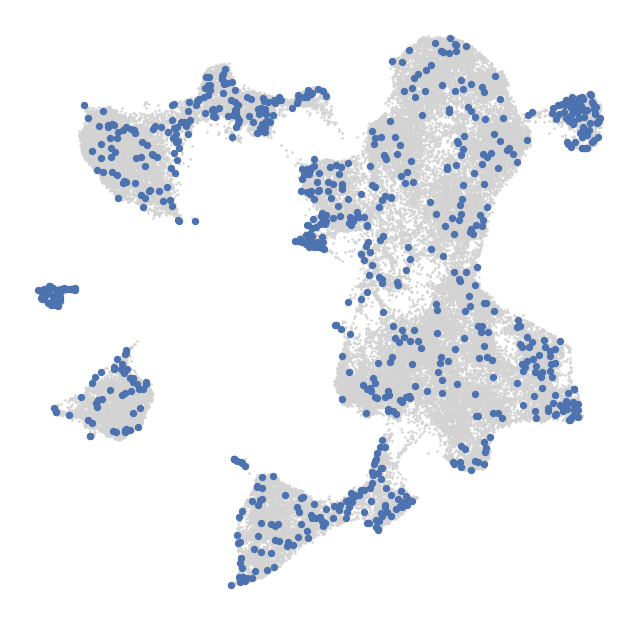

In [45]:
# Plot the initilization to ensure they are evenly spread
SEACells.plot.plot_initialization(ad_atac, model)

In [46]:
# the model was fit on the cluster
model.fit(n_iter=20)

Randomly initialized A matrix.
Setting convergence threshold at 0.00905021146581154
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 20 iterations.


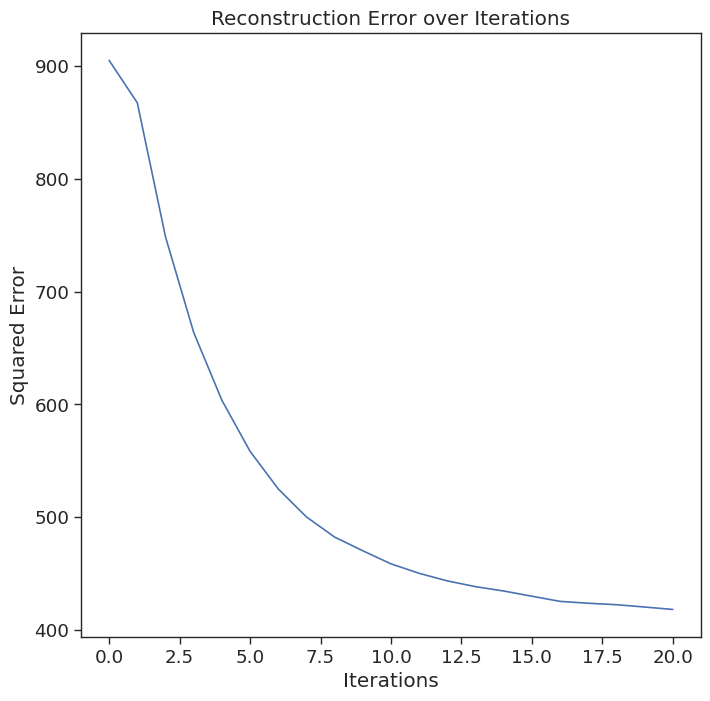

In [51]:
model.plot_convergence()

In [56]:
#sc.write(filename = data_dir + "perturbation_sea.h5ad", adata = ad_atac)

In [61]:
ad = sc.read_h5ad(data_dir + "perturbation_sea.h5ad")

In [78]:
ad.obs["SEACell"].isnull().values.any()

False

Save the dataframe which contains SEACell annotations for use in R.

In [79]:
ad.obs.to_csv(data_dir + "perturbation_sea_df_new", index = True)

In [ ]:
# the function below requires csr as a layer key
#ad.layers["csr"] = ad.X

In [ ]:
#SEACell_ad = SEACells.core.summarize_by_SEACell(ad, SEACells_label='SEACell', summarize_layer='csr')
#SEACell_ad

## Normalization

Normalization of metacell data can be performed using the `sc.pp.normalize_total` and `sc.pp.log1p` functions

## Visualizing Results

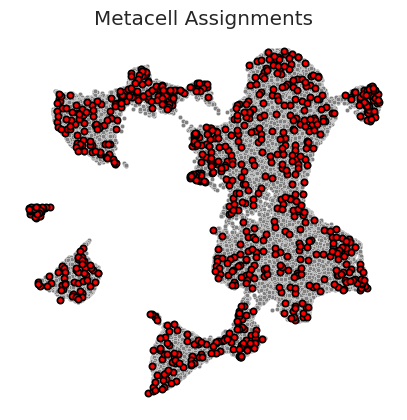

In [62]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=False)

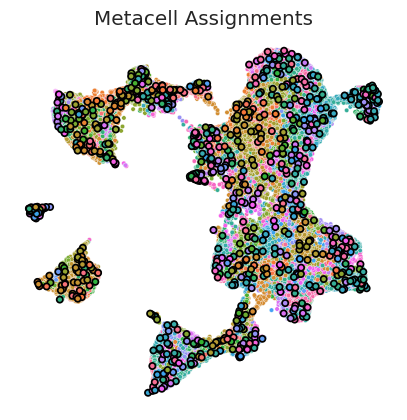

In [64]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=True)

/omics/groups/OE0533/internal/katharina/seacells_yml/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


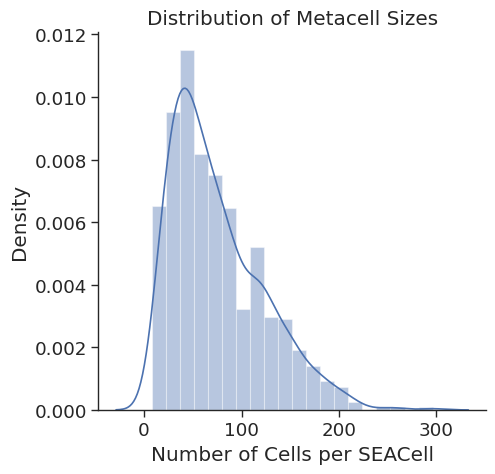

,size
SEACell,
E7.5_rep1#AAAGGAGCATTAGCCA-1,55
E7.5_rep1#AAAGGCTCAAGGATTA-1,42
E7.5_rep1#AACATAGCAAGCTTTG-1,110
E7.5_rep1#AACCGCTCATGTTTGG-1,93
E7.5_rep1#AACCTAATCTCACTCA-1,46
...,...
E8.75_rep2#TGAGAACCATTGCGGT-1,32
E8.75_rep2#TGATCAGGTGAAACAA-1,55
E8.75_rep2#TGTATCCGTTTATCTG-1,88


In [65]:
SEACells.plot.plot_SEACell_sizes(ad, bins=20)

## Quantifying Results

SEACells also implements methods for visualizing the results of the SEACells algorithm 
    <ul> 
        <li>```.compute_celltype_purity(ad, col_name)``` computes the purity of different celltype labels within a SEACell metacell. Typically, col_name='celltype' or similar. Returns a pd.DataFrame of length n_SEACells.
        <li>```.compactness(ad, low_dim_embedding)``` computes the per-SEAcell variance in diffusion components. ```low_dim_embedding``` is a string specifying the low dimensional embedding with which diffusion components are calculated, typically 'X_pca' for RNA or 'X_svd' for ATAC. Lower values of compactness suggest more compact/lower variance metacells.
        <li>```separation(ad, low_dim_embedding,nth_nbr=1,cluster=None)``` computes the diffusion distance between a SEACell and its ```nth_nbr```. As before, ```low_dim_embedding``` is a string specifying the low dimensional embedding with which diffusion components are calculated, typically 'X_pca' for RNA or 'X_svd' for ATAC. If ```cluster``` is provided as a string, e.g. 'celltype', nearest neighbors are restricted to have the same celltype value.  Higher values of separation suggest better distinction between metacells.
    </ul>
    


In [66]:
SEACell_purity = SEACells.evaluate.compute_celltype_purity(ad, col_name = 'celltype.mapped')

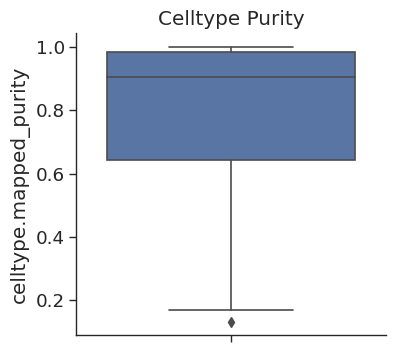

,celltype.mapped,celltype.mapped_purity
SEACell,,
E7.5_rep1#AAAGGAGCATTAGCCA-1,Gut,0.836364
E7.5_rep1#AAAGGCTCAAGGATTA-1,Def._endoderm,0.619048
E7.5_rep1#AACATAGCAAGCTTTG-1,Anterior_Primitive_Streak,0.345455
E7.5_rep1#AACCGCTCATGTTTGG-1,ExE_ectoderm,0.989247
E7.5_rep1#AACCTAATCTCACTCA-1,Def._endoderm,0.760870


In [67]:
plt.figure(figsize=(4,4))
sns.boxplot(data=SEACell_purity, y='celltype.mapped_purity')
plt.title('Celltype Purity')
sns.despine()
plt.show()
plt.close()

SEACell_purity.head()

Determing nearest neighbor graph...


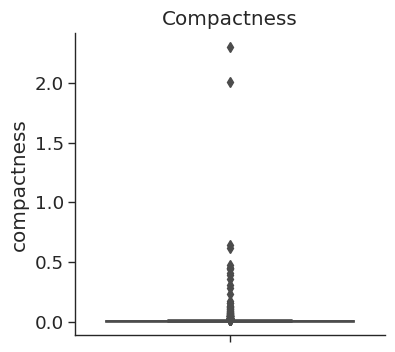

,compactness
SEACell,
E7.5_rep1#AAAGGAGCATTAGCCA-1,0.002657
E7.5_rep1#AAAGGCTCAAGGATTA-1,0.009740
E7.5_rep1#AACATAGCAAGCTTTG-1,0.015302
E7.5_rep1#AACCGCTCATGTTTGG-1,0.002337
E7.5_rep1#AACCTAATCTCACTCA-1,0.008162


In [69]:
compactness = SEACells.evaluate.compactness(ad, 'X_PeakVI_10_dim')

plt.figure(figsize=(4,4))
sns.boxplot(data=compactness, y='compactness')
plt.title('Compactness')
sns.despine()
plt.show()
plt.close()

compactness.head()

Determing nearest neighbor graph...


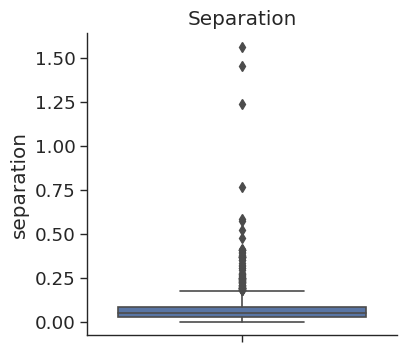

,separation
SEACell,
E7.5_rep1#AAAGGAGCATTAGCCA-1,0.061309
E7.5_rep1#AAAGGCTCAAGGATTA-1,0.144949
E7.5_rep1#AACATAGCAAGCTTTG-1,0.076239
E7.5_rep1#AACCGCTCATGTTTGG-1,0.017856
E7.5_rep1#AACCTAATCTCACTCA-1,0.086745


In [68]:
separation = SEACells.evaluate.separation(ad, 'X_PeakVI_10_dim',nth_nbr=1)

plt.figure(figsize=(4,4))
sns.boxplot(data=separation, y='separation')
plt.title('Separation')
sns.despine()
plt.show()
plt.close()

separation.head()

# Aggregating both the peak counts and the gene expression counts 

I ran this on the cluster, because it was using too much memory. (see "SEACells/cluster job for aggregation")

In [80]:
#ad_atac.layers["csr"] = ad_atac.X
#atac_meta_ad, rna_meta_ad = SEACells.genescores.prepare_multiome_anndata(ad, ad_rna, SEACell_label='SEACell')
#sc.write(data_dir + "atac_pert_sea_agg.h5ad", adata = atac_meta_ad)
#sc.write(data_dir + "rna_pert_sea_agg.h5ad", adata = rna_meta_ad)

In [82]:
atac_meta_ad = sc.read_h5ad(data_dir + "atac_pert_sea_agg.h5ad" )
rna_meta_ad = sc.read_h5ad(data_dir + "rna_pert_sea_agg.h5ad")

In [ ]:
atac_meta_ad.obs

### Saving RNA data

In [ ]:
ad_rna.X.shape

In [ ]:
rna_meta_ad.var_names = ad_rna.var.name.to_list()

In [ ]:
df = pd.DataFrame(rna_meta_ad.X.todense())

In [ ]:
df.to_csv(data_dir + "SEA_aggregates_to_R/rna_agg_matrix.csv", index = False) 

In [ ]:
seacell_names = pd.DataFrame(rna_meta_ad.obs_names)#.to_list()

In [ ]:
seacell_names.to_csv(data_dir + "SEA_aggregates_to_R/rna_cell_names.csv", index = False)

In [ ]:
pd.DataFrame(rna_meta_ad.var_names).to_csv(data_dir + "SEA_aggregates_to_R/rna_gene_names.csv", index = False)

### Saving ATAC data

In [ ]:
atac_meta_ad.obs.to_csv(data_dir + "SEA_aggregates_to_R/atac_agg_colData.csv")

In [ ]:
atac_meta_ad.var.to_csv(data_dir + "SEA_aggregates_to_R/atac_agg_rowData.csv")

In [ ]:
pd.DataFrame(atac_meta_ad.X.todense()).to_csv(data_dir + "SEA_aggregates_to_R/peak_agg_matrix.csv", index = False)

In [ ]:
pd.DataFrame(atac_meta_ad.obs_names).to_csv(data_dir + "SEA_aggregates_to_R/atac_cell_names.csv", index = False)
pd.DataFrameame(atac_meta_ad.var_names).to_csv(data_dir + "SEA_aggregates_to_R/atac_peak_names.csv", index = False)

# Gene-peak correlations

# Assign celltypes to SEACells


In [ ]:
rna_meta_ad

In [ ]:
ad.obs["SEACell"]

In [ ]:
ad1 = ad[ad.obs["SEACell"].isin(atac_meta_ad.obs_names.to_list()), :]

In [ ]:
ad[ad.obs["SEACell"].isin(rna_meta_ad.obs_names.to_list()), :]

In [ ]:
ad.obs["SEACell"].groupby("SEACell")

In [ ]:
help(pd.Series.mode)

In [ ]:
test = pd.DataFrame(ad.obs.groupby("SEACell").apply(lambda x: pd.Series(x["celltypes"]).mode()))

In [ ]:
test.SEACell.isin(rna_meta_ad.obs_names)

In [ ]:
test["SEACell"] = test.index

In [ ]:
test["SEACell"].isin(rna_meta_ad.obs_names)

In [ ]:
rna_meta_ad.obs_names

In [ ]:
test[test.SEACell.isin(rna_meta_ad.obs_names), :]

In [ ]:
rna_meta_ad.obs["celltype"] = ad1.obs.groupby("SEACell").apply(lambda x: pd.Series(x["celltypes"]).mode())

In [ ]:
x = ad1.obs.groupby("SEACell").apply(lambda x: pd.Series(x["celltypes"]).mode())#

In [ ]:
pd.DataFrame(x.index.get_level_values(0).tolist())[0].isin(rna_meta_ad.obs_names)#)== False)

In [ ]:
ad.obs.SEACell.unique().shape

In [ ]:


rna_meta_ad.obs

In [ ]:
rna_meta_ad.obs["celltypes"] = ad.obs.groupby("SEACell").apply(lambda x: pd.Series(x["celltypes"]).mode())#.to_list()

In [ ]:
rna_meta_ad.obs

### Normalize and log transform this new data

This is very important to normalize again.

In [ ]:
help(sc.pp.log1p)

In [ ]:
# Normalize and log transform the data
sc.pp.normalize_per_cell(rna_meta_ad, counts_per_cell_after=10000)
sc.pp.log1p(rna_meta_ad)

# Select highly variable genes
sc.pp.highly_variable_genes(rna_meta_ad)

# Perform PCA and UMAPs
sc.tl.pca(rna_meta_ad, n_comps=50, use_highly_variable=True)
sc.pp.neighbors(rna_meta_ad, n_neighbors=5)
sc.tl.umap(rna_meta_ad)

In [ ]:
rna_meta_ad.obs

In [ ]:
sc.pl.scatter(rna_meta_ad, basis='umap', color='celltype', frameon=False)


# ChromVar

First we will create an anndata object containing the motif deviations. We will add the ATAC UMAP as well. 

In [ ]:
# get umap coordinates from original anndata object
atac_umap = pd.DataFrame(ad.obsm["X_umap"], index = ad.obs_names)

In [ ]:
# take mean coordinate for SEACell aggregates and add to aggregate anndata objects
atac_meta_ad.obsm["X_umap"] = atac_umap.groupby(ad.obs["SEACell"]).mean().loc[atac_meta_ad.obs_names, :].values
rna_meta_ad.obsm["X_umap"] = atac_umap.groupby(ad.obs["SEACell"]).mean().loc[atac_meta_ad.obs_names, :].values

In [ ]:
# read in deviation matrix
dev = pd.read_csv(data_dir + "SEA_aggregates_to_R/deviations.csv", index_col = 0)
dev_matrix = dev.to_numpy()

In [ ]:
# create anndata for peaks
dev_ad = sc.AnnData(dev.to_numpy().T)
dev_ad.obs_names = dev.columns
dev_ad.var_names = dev.index
dev_ad.obsm["X_umap"] = rna_meta_ad.obsm["X_umap"]

In [ ]:
rna_meta_ad.var = ad_rna.var

In [ ]:
rna_meta_ad.var_names = ad_rna.var["name"].to_list()
rna_meta_ad.var = ad_rna.var

In [ ]:
rna_meta_ad.var_names

In [ ]:
genes = ["Gata2", "Gata1"]
temp = rna_meta_ad[:, genes]

In [ ]:
atac_meta_ad

In [ ]:
ad_rna.obsm["X_umap"] = ad.obsm["X_umap"]

In [ ]:
sc.pl.scatter(dev_ad, basis = "umap", color = ["Gata1387", "Gata5385"], title = ["Gata1", "Gata5"])

In [ ]:
sc.pl.scatter(dev_ad, basis = "umap", color = ["Gata6382", "Gata2383", "Gata3384", "Gata5385", "Gata4386", "Gata1387"], )

In [ ]:
temp.layers["GeneAccessibility"] = atac_meta_ad[rna_meta_ad.obs_names].obsm["GeneAccessibility"][genes].values